# Scalable Computing on the Planetary Computer

In this deep-dive, we cover working with large datasets. We'll start with a brief introduction to [Dask](https://dask.org/), and then see some general principles of parallelization and big data systems.

## Dask Intro

Dask, like many "big data" systems, works by breaking up large computations into many smaller computations. Those many smaller computations can (hopefully) be run in parllel, hopefully getting your result faster.

Let's consider a simple example. Incrementing two numbers, and then adding them together.

In [1]:
import dask
import time


def inc(x):
    time.sleep(1)
    return x + 1


def add(x, y):
    time.sleep(1)
    return x + y

When we run this, we see it takes about 3 seconds.

In [2]:
%%time

a = inc(1)
b = inc(2)
c = add(a, b)

CPU times: user 2.18 ms, sys: 358 µs, total: 2.54 ms
Wall time: 3 s


Now let's use Dask, specifically [`dask.delayed`](https://docs.dask.org/en/latest/delayed.html), to run this workload.

In [3]:
inc_ = dask.delayed(inc)
add_ = dask.delayed(add)

In [4]:
%%time
a = inc_(1)
b = inc_(2)
c = add_(a, b)

CPU times: user 1.13 ms, sys: 130 µs, total: 1.26 ms
Wall time: 913 µs


That block thook less than 1 ms! Is Dask magic? No.

In [5]:
c

Delayed('add-880e2804-004e-49c8-8375-869a663adb94')

Instead of evaluating the reuslt immediately, Dask has built up a "Delayed" result. This is kind of like a recipe for the computation, which we can visualize.

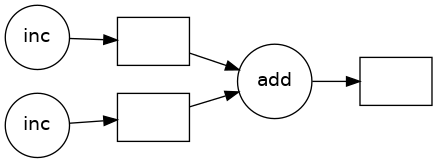

In [6]:
c.visualize(rankdir="LR")

And we can call `.compute()` to get the actual result.

In [8]:
%time c.compute()

CPU times: user 5.09 ms, sys: 1.03 ms, total: 6.11 ms
Wall time: 2.01 s


5

So, Dask works by taking big problems, and breaking them into smaller tasks. These tasks are like a recipe of the computation (read these files, call this function, combine these outputs, etc.).

Building task graphs "by hand" is painful. Python has all these wonderful high-level APIs for working with data. 

Dask, and libraries outside of Dask, offer various ways to build these task graphs for you.

<img src="https://docs.dask.org/en/latest/_images/dask-overview.svg">

So, by using these high-level "collections" you get familiar APIs and parallelization with Dask.

## Distributed computing introduction

Distributed computing, where we do a computation on multiple machines, is generally hard. There's some fundamental complexity around coordinating many communication, synchronization, algorithms, etc. And then there's some incidental complexity around just getting the cluster of macines set up in the first place.

With the Planetary Computer Hub, we've tried to reduce the incidental complexity as much as possible. For most use cases, creating a cluster is as easy as:

In [9]:
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(24)

cluster

Now computations that use Dask will happen on the cluster.

## Avoid unnecessary work

The fastest way to do something is to not do it at all.

The Sentinel-2 Level 2-A dataset consists of millions of images. Using the Planetary Computer's STAC API we can narrow those millions of images down to a few hundered of interest by specifying an area or time of interest.

In [10]:
import shapely.geometry

d = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-89.43695068359375, 28.990123601014233],
                        [-89.09500122070312, 28.990123601014233],
                        [-89.09500122070312, 29.29059098231747],
                        [-89.43695068359375, 29.29059098231747],
                        [-89.43695068359375, 28.990123601014233],
                    ]
                ],
            },
        }
    ],
}
bbox = shapely.geometry.shape(d["features"][0]["geometry"]).bounds
bbox = [round(x, 4) for x in bbox]
bbox

[-89.437, 28.9901, -89.095, 29.2906]

In [11]:
import pystac_client

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
bbox = [-89.437, 28.9901, -89.095, 29.2906]


search = catalog.search(
    collections=["sentinel-2-l2a"], bbox=bbox, query={"eo:cloud_cover": {"lt": 25}}
)
items = search.get_all_items()
len(items)

143

In [12]:
import requests
from ipyleaflet import Map, TileLayer, GeoJSON, FullScreenControl
import shapely.geometry

item = sorted(items, key=lambda x: x.properties["eo:cloud_cover"])[1]

center = shapely.geometry.shape(item.geometry).centroid.bounds[:2][::-1]

m = Map(center=center, zoom=8)
layer = TileLayer(
    url=requests.get(item.assets["tilejson"].href).json()["tiles"][0],
)
m.add_layer(layer)
m.add_layer(
    GeoJSON(
        data=shapely.geometry.mapping(shapely.geometry.box(*bbox)),
        style={"fillOpacity": 0},
    )
)

m.scroll_wheel_zoom = True
m.add_control(FullScreenControl())
m

Map(center=[29.331450182421634, -89.50911194786401], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [13]:
import stackstac
import planetary_computer

signed_items = []
for item in items:
    item = item.clone()
    item.clear_links()
    signed_items.append(planetary_computer.sign(item).to_dict())

In [19]:
import warnings

warnings.filterwarnings("ignore", "Creating")

In [20]:
ds = stackstac.stack(signed_items, resolution=10, chunksize=2048)
ds

,Array,Chunk
Bytes,2.32 TiB,32.00 MiB
Shape,"(143, 17, 11454, 11456)","(1, 1, 2048, 2048)"
Count,92414 Tasks,87516 Chunks
Type,float64,numpy.ndarray


In [22]:
assets = ["B02", "B03", "B04", "B08"]

ds = stackstac.stack(
    signed_items, assets=assets, bounds_latlon=bbox, chunksize=2048
).where(lambda x: x > 0)

names = dict(zip(ds.band.values, ds.common_name.values))
bands = [names[v] for v in ds.band.values]

ds = ds.assign_coords(band=bands)
ds

,Array,Chunk
Bytes,49.11 GiB,32.00 MiB
Shape,"(143, 4, 3396, 3393)","(1, 1, 2048, 2048)"
Count,8012 Tasks,2288 Chunks
Type,float64,numpy.ndarray


In [23]:
ds

,Array,Chunk
Bytes,49.11 GiB,32.00 MiB
Shape,"(143, 4, 3396, 3393)","(1, 1, 2048, 2048)"
Count,8012 Tasks,2288 Chunks
Type,float64,numpy.ndarray


In [24]:
ds = ds.persist()

red = ds.sel(band="red")
blue = ds.sel(band="blue")
green = ds.sel(band="green")
nir = ds.sel(band="nir")

ndvi = (nir - red) / (nir + red)

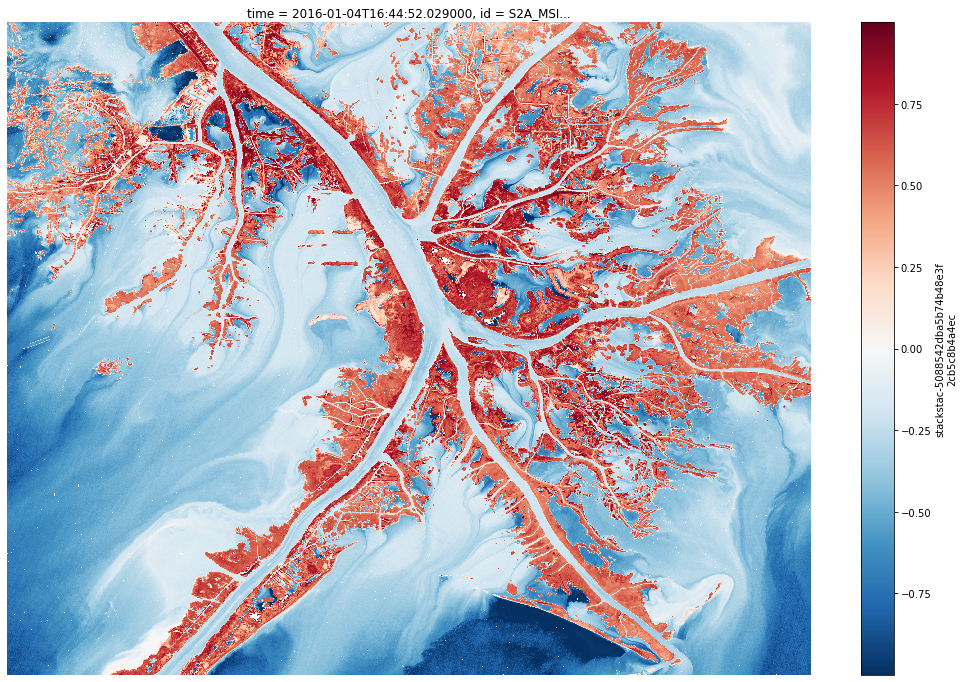

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 12))

ndvi.isel(time=4).plot.imshow(ax=ax)
ax.set_axis_off()

**What just happened?**

The Planetary Computer Hub is configured [Dask Gateway](https://gateway.dask.org/) which, according to its documentation,

> provides a secure, multi-tenant server for managing Dask clusters. It allows users to launch and use Dask clusters in a shared, centrally managed cluster environment, without requiring users to have direct access to the underlying cluster backend (e.g. Kubernetes, Hadoop/YARN, HPC Job queues, etc…).

If you don't know what Kubernetes or Hadoop is, that's the point! You really shouldn't have to know about things like tolerations in order to do geospatial data analysis at scale.

In [34]:
import dask

dask.config.config["gateway"]

{'auth': {'type': 'jupyterhub', 'kwargs': {}},
 'cluster': {'options': {'image': '{JUPYTER_IMAGE_SPEC}'}},
 'public_address': 'https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/',
 'address': 'http://proxy-http:8000/compute/services/dask-gateway/',
 'proxy_address': 'gateway://traefik-dhub-prod-dask-gateway.prod:80',
 'http-client': {'proxy': True}}

In [35]:
diff = ndvi - ndvi.max(dim="time")

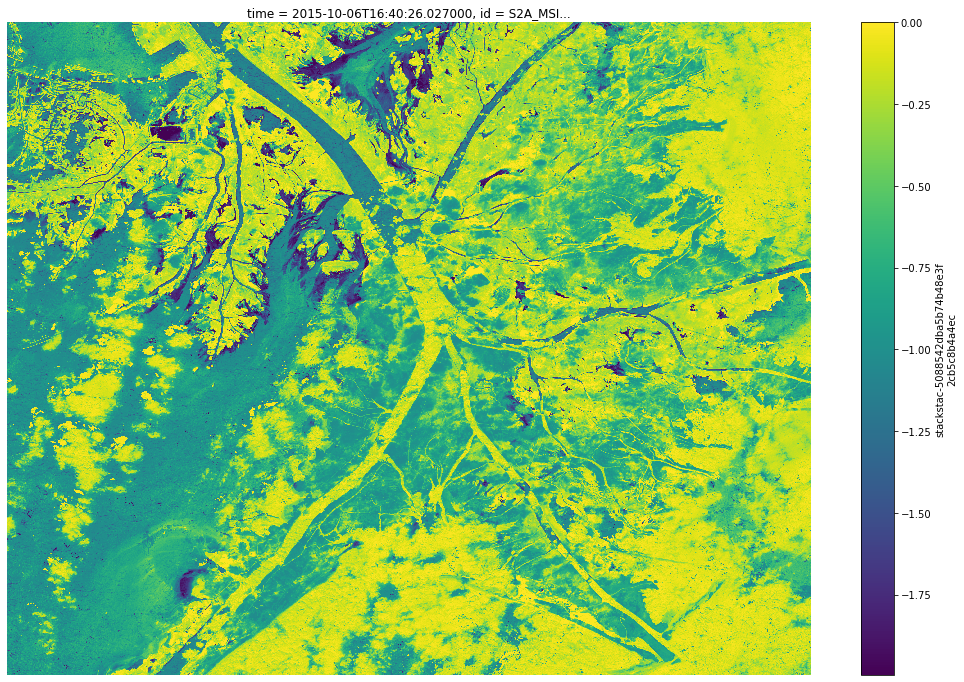

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 12))

diff.isel(time=0).plot.imshow(ax=ax)
ax.set_axis_off()

In [37]:
client.restart()

Connection method: Cluster object,Cluster type: GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.268e1b7c1ffa4cc1a2873270a18d3d55/status,


## Customize your cluster

`GatewayCluster()` works great for the common case, but what if your workload requires some customization? For example, what if you need more memory on your workers, or need to set an environment variable?

In this case, you can connect to the gateway and use `cluster_options` to customize things.

In [38]:
import dask_gateway

gateway = dask_gateway.Gateway()
cluster_options = gateway.cluster_options()
cluster_options

In [40]:
cluster_options.worker_memory = 16

In [41]:
cluster = gateway.new_cluster(cluster_options)
client = cluster.get_client()
cluster.scale(2)
cluster

## Next steps

* Read about the Hub: https://planetarycomputer.microsoft.com/docs/overview/environment/
* Read about Dask: https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/
* Dask examples: https://examples.dask.org/
* Dask tutorial: https://tutorial.dask.org/